<a href="https://colab.research.google.com/github/PremKumar-V/NLP_Projects/blob/main/Predict_Next_Word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Next Word

- [Dataset Link](https://huggingface.co/datasets/oscar)

## Prepare the Notebook

In [1]:
# Install Packages

!pip install pytorch-lightning torchmetrics torchviz datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.2 MB/s eta 0:00:00


In [2]:
# Import Packages

from datasets import load_dataset
import pandas as pd

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

import torch
import torch.nn as nn
import torch.optim as optim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Import Dataset

trainDf = load_dataset("amazon_reviews_multi", "en", split = 'train')
valDf = load_dataset("amazon_reviews_multi", "en", split = 'validation')
testDf = load_dataset("amazon_reviews_multi", "en", split = 'test')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


## Exploratory Data Analysis

In [4]:
import re


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

In [5]:
trainDf

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 200000
})

In [14]:
from typing import List

def changeToDataFrame(df: pd.DataFrame) -> List[str]:
    dataframe = pd.DataFrame(df)['review_body']
    return pd.DataFrame(dataframe)

trainDf = changeToDataFrame(trainDf)
valDf = changeToDataFrame(valDf)
testDf = changeToDataFrame(testDf)

In [15]:
trainDf = trainDf[:25000]

In [16]:
def clean(text: str) -> List[str]:
    text = text.lower()
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = [word for word in text.split() if word not in stopwords.words('english')]
    return text

In [20]:
" ".join(clean(trainDf['review_body'][0]))

'arrived broken manufacturer defect two legs base completely formed way insert casters unpackaged entire chair hardware noticing ill spend twice amount time boxing whole useless thing send back 1-star review part chair never got sit go far include picture injection molding quality assurance process missed though hesitant buy makes wonder arent missing structures supports dont impede assembly process'

In [21]:
trainDf['textArray'] = trainDf['review_body'].apply(clean)

In [22]:
valDf.shape, testDf.shape

((5000, 1), (5000, 1))

In [24]:
from tqdm import trange

corpusData = []

for i in trange(trainDf.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpusData += trainDf['textArray'][i]
len(corpusData)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 127855.48it/s]


410228

In [25]:
from collections import Counter

most_common = Counter(corpusData).most_common(10)
most_common

[('product', 4560),
 ('one', 4405),
 ('would', 3357),
 ('like', 3012),
 ('work', 2788),
 ('dont', 2529),
 ('get', 2510),
 ('money', 2360),
 ('even', 2307),
 ('received', 2296)]

In [26]:
words, freqs = [], []

for word, freq in most_common:
    words.append(word)
    freqs.append(freq)

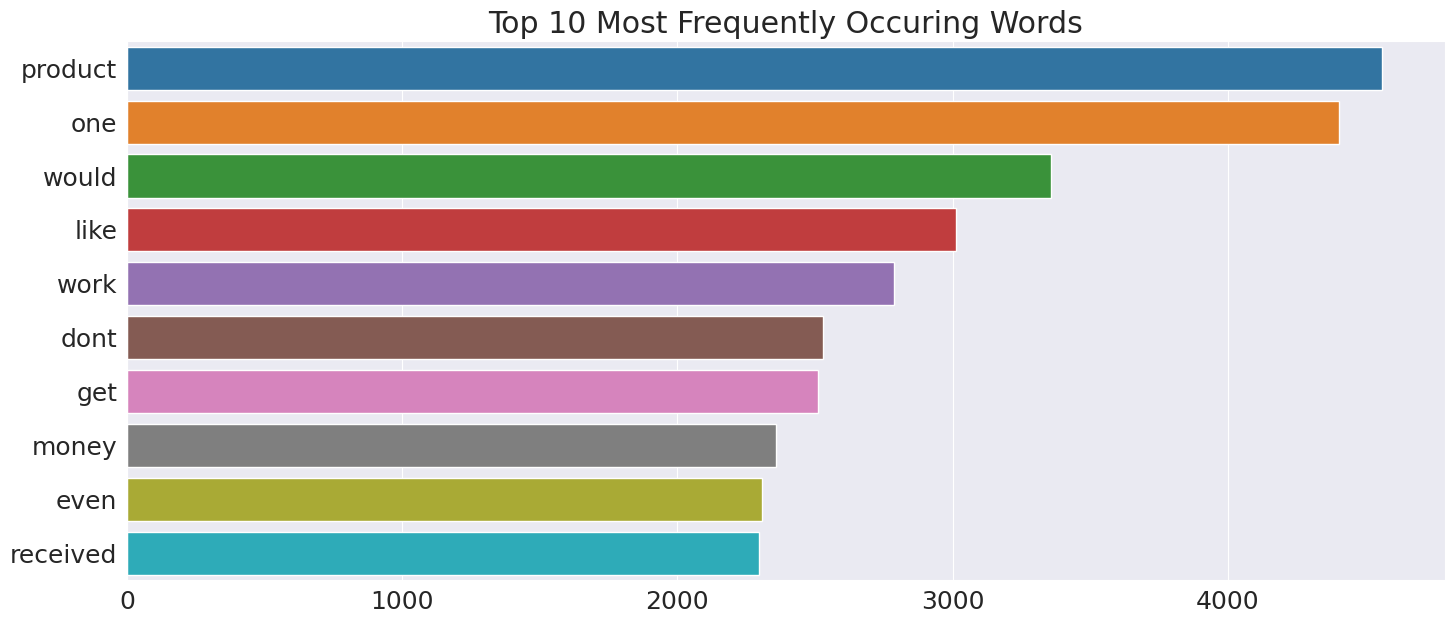

In [27]:
sns.barplot(x=freqs, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

In [32]:
from sklearn.feature_extraction import text
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet = True)

englishStopwords = stopwords.words('english')

def n_grams(ngrams):
    cv = text.CountVectorizer(ngram_range = ngrams, stop_words=englishStopwords)
    grams = cv.fit_transform(trainDf['review_body'])
    count_values = grams.toarray().sum(axis=0)
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]

    sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
    plt.title(f'Top 10 Most Frequently Occuring {ngrams[0]}-grams')
    plt.show()

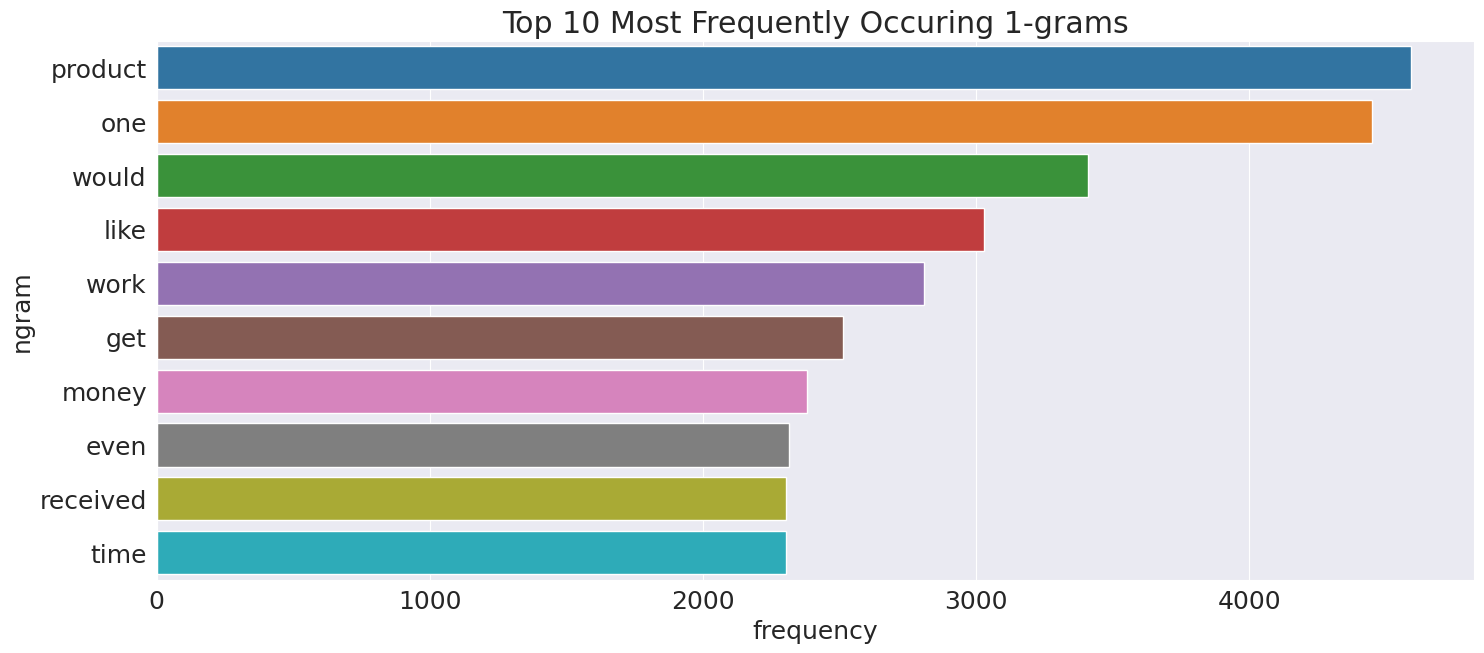

In [33]:
n_grams((1, 1))

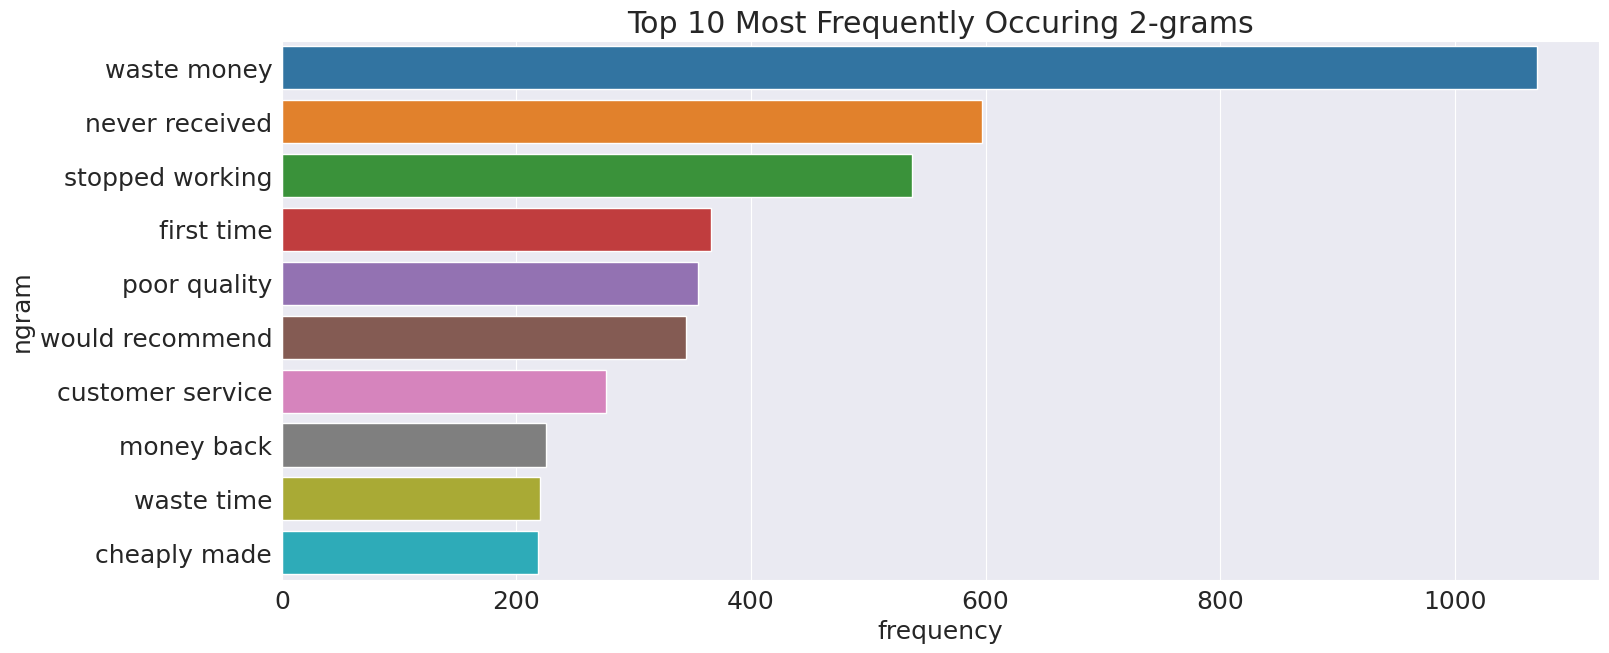

In [34]:
n_grams((2, 2))

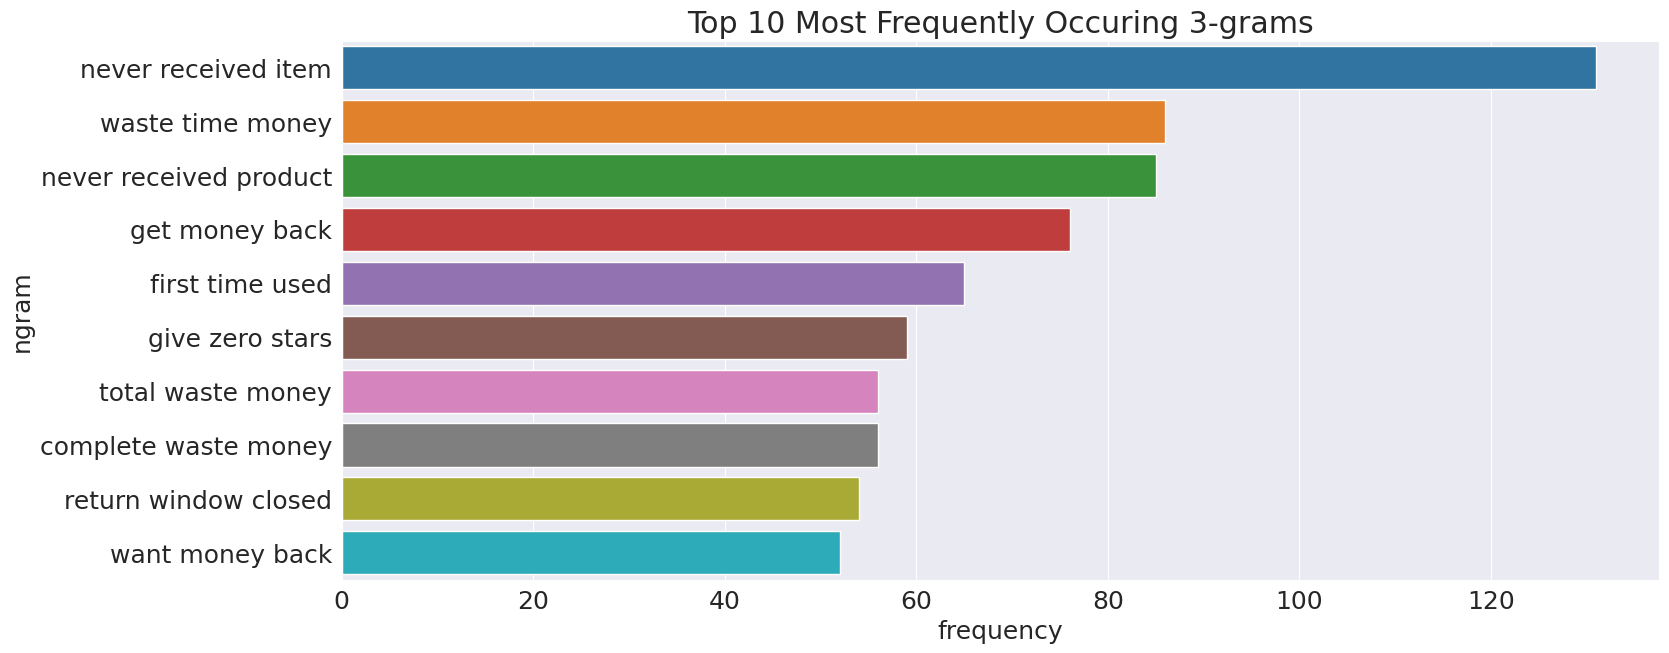

In [36]:
n_grams((3, 3))

## Preprocessing